In [11]:
# Import libraries

!pip install pygame
#import os
#os.environ['SDL_VIDEODRIVER']='dummy'
#import pygame
#pygame.display.set_mode((640,480))

from IPython.display import clear_output
from time import sleep

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions import Categorical
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
# User Inputs

gamma = 0.99  # Reward discount factor for each future step (lower value means more focus on shorter-term rewards)
seed = 543  # Random seed
render = False  # Render the environment
logInterval = 20  # Interval between training status logs

In [4]:
# Reinforcement Learning Environment

# CartPole is trying to solve the inverted pendulum problem
# 4 inputs (cart position, cart veloc, pole angle, and pole ang veloc) and 2 outputs (push cart left, push cart right)
# The reward is +1 for every iteration through the environment (state->action->results) that the pole is kept upright
# Certain conditions (e.g. cart going too far) will terminate the session
# This if loop is a hack, original code had "if render: env.render()" in main training loop, but if render_mode=human,
# the render popup comes up regardless
if render:
    env = gym.make('CartPole-v1', render_mode='human', new_step_api=True)
else:
    env = gym.make('CartPole-v1', new_step_api=True)
env.reset(seed=seed)
torch.manual_seed(seed)

In [5]:
# Create Policy

# Policy network is a 3-layer network, 4-128-2
# We define the PyTorch network and the forward operation, which returns the softmax of the two output options
class Policy(nn.Module):
    def __init__(self):
        super(Policy, self).__init__()
        self.affine1 = nn.Linear(4, 128)
        self.dropout = nn.Dropout(p=0.5)
        self.affine2 = nn.Linear(128, 2)

        self.saved_log_probs = [] # Used to save the action decisions at each interval
        self.rewards = [] # Used to save rewards at each interval

    def forward(self, x):
        x = self.affine1(x)
        x = self.dropout(x)
        x = F.relu(x)
        action_scores = self.affine2(x)
        return F.softmax(action_scores, dim=1)

# Instantiate the network and define the network optimizer
nnPolicy = Policy()
optimizer = optim.Adam(nnPolicy.parameters(), lr=1e-2)

# Epsilon is the machine error term
eps = np.finfo(np.float32).eps.item()

In [6]:
# Execute Model Function

# Runs the policy given inputs to get action probabilities and sample a decision
def select_action(state):

    # Recast input as torch tensor
    state = torch.from_numpy(state).float().unsqueeze(0)

    # output = model(input)
    probs = nnPolicy(state)

    # Get outputs as categorical probabilities and sample from it to get the action
    m = Categorical(probs=probs)
    action = m.sample()

    # Append the decided action log probability to the policy ledger
    nnPolicy.saved_log_probs.append(m.log_prob(action))

    return action.item()

In [7]:
# Update Policy Network

def finish_episode():

    # Initialize marginal reward, policy loss value per step, and cumulative reward per step
    R = 0
    policy_loss = []
    cumulRewards = []

    # Gather the cumulative discounted rewards in reverse order (such that action 1 aligns with total reward)
    # The first action affects all subsequent rewards, the last action only affects the last reward
    for reward in nnPolicy.rewards[::-1]:
        R = reward + gamma * R
        cumulRewards.insert(0, R)
    cumulRewards = torch.tensor(cumulRewards)
    cumulRewards = (cumulRewards - cumulRewards.mean()) / (cumulRewards.std() + eps)

    # Loss for each step is log_prob times the cumulative reward
    for log_prob, cumulReward in zip(nnPolicy.saved_log_probs, cumulRewards):
        policy_loss.append(-log_prob * cumulReward)

    # Sum all of the losses for the episode together and step the policy network optimizer
    # The gradient graph goes back from the policy_loss sum through the policy probabilities to the policy network
    optimizer.zero_grad()
    policy_loss = torch.cat(policy_loss).sum()
    policy_loss.backward()
    optimizer.step()

    # Clear out policy rewards and log probabilities
    del nnPolicy.rewards[:]
    del nnPolicy.saved_log_probs[:]

In [8]:
# Run RL Training

# Initialize the total running reward across episodes used to compare against environment win threshold
runningReward = 10

# Run for a maximum of 500 training episodes
for iEp in range(0, 500):

    # Reset environment and initialize running episode reward for the new episode
    state= env.reset()
    epReward = 0

    # Learning during the iEp'th episode
    for t in range(1, 10000):  # Don't infinite loop while learning

        # Get action from the policy network and interact with env to get new state, step reward, and done signal
        # Also add reward to policy ledger and total episode reward
        action = select_action(state)
        state, reward, done, _, _ = env.step(action)
        nnPolicy.rewards.append(reward)
        epReward += reward

        if done: break

    # Update the running reward using an EMA
    runningReward = 0.05 * epReward + (1 - 0.05) * runningReward

    # Update policy network from episode
    finish_episode()

    # Print episode status
    if iEp % logInterval == 0:
        print('Episode {}\tLast Reward: {:.2f}\tRunning Avg Reward: {:.2f}'.format(iEp, epReward, runningReward))

    # Check for if simulation passes the reward threshold
    if runningReward > env.spec.reward_threshold:
        print("Solved! Running reward is now {} and the last episode runs to {} time steps!".format(runningReward, t))
        break

Episode 0	Last Reward: 40.00	Running Avg Reward: 11.50
Episode 20	Last Reward: 24.00	Running Avg Reward: 24.27
Episode 40	Last Reward: 122.00	Running Avg Reward: 73.61
Episode 60	Last Reward: 250.00	Running Avg Reward: 105.14
Episode 80	Last Reward: 137.00	Running Avg Reward: 241.98
Episode 100	Last Reward: 316.00	Running Avg Reward: 318.40
Episode 120	Last Reward: 587.00	Running Avg Reward: 438.20
Solved! Running reward is now 521.4379100303569 and the last episode runs to 1492 time steps!


Running Trained Model for 100 Episodes
Average Reward over 100 Trials: 1712.36


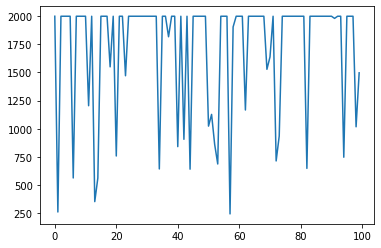

In [9]:
# Run Trained Model

nEps = 100
print('Running Trained Model for {} Episodes'.format(nEps))

for iEp in range(nEps):
    state = env.reset()
    epReward = 0

    # Learning during the iEp'th episode
    for t in range(1, 2000):  # Don't infinite loop while learning

        # Get action from the policy network and interact with env to get new state, step reward, and done signal
        # Also add reward to policy ledger and total episode reward
        action = select_action(state)
        state, reward, done, _, _ = env.step(action)
        epReward += reward

        if done:
            break

    nnPolicy.rewards.append(epReward)

print('Average Reward over {} Trials: {}'.format(nEps, sum(nnPolicy.rewards) / len(nnPolicy.rewards)))
plt.plot(list(range(100)), nnPolicy.rewards)
plt.show()

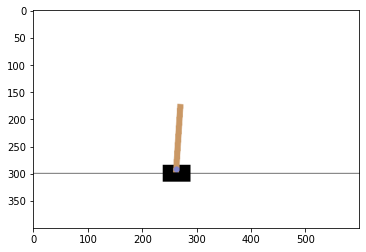

Render Ran for 99.0 Steps


In [20]:
# Render 1 Episode

print('Rendering 1 Trained Run')

env = gym.make('CartPole-v1', render_mode='rgb_array', new_step_api=True)
state = env.reset()
epReward = 0

for t in range(1, 100):  # Don't infinite loop while learning

    #env.render()
    clear_output(wait=True)
    env_screen = env.render()
    plt.imshow(np.squeeze(np.array(env_screen)))
    plt.show()
    sleep(0.1)

    # Get action from the policy network and interact with env to get new state, step reward, and done signal
    # Also add reward to policy ledger and total episode reward
    action = select_action(state)
    state, reward, done, _, _ = env.step(action)
    epReward += reward

    if done:
        break

print('Render Ran for {} Steps'.format(epReward))

env.close()